# Crypto Currency Returns

Lets get some data about the price of several crypto currencies and then analyze the price, and correlation between them.  We can also graph which currencies were the most profitable!

In [1]:
import pandas as pd
import requests
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [8]:
from_symbol = 'ETH'
to_symbol = 'USD'
exchange = 'Bitstamp' # Coinbase
datetime_interval = 'day'
data_path = '/content/drive/MyDrive/Colab Notebooks/data/crypto_data/'

In [13]:
def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date, data_path=''):
    return '%s%s_%s_%s_%s_%s.csv' % (data_path, from_symbol, to_symbol, exchange, datetime_interval, download_date)

def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals
    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)
    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data

def convert_to_dataframe(data):
    df = pd.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df

def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df

In [9]:
data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)
current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime, data_path=data_path)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

Filtering 694 empty datapoints
Saving data to /content/drive/MyDrive/Colab Notebooks/data/crypto_data/ETH_USD_Bitstamp_day_2021-06-07.csv


At this point we'll assume we have the data downloaded. 

In [11]:
def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

In [14]:
df_btc = read_dataset(get_filename('BTC', 'USD', 'Bitstamp', 'day', '2021-06-06',data_path=data_path))
df_eth = read_dataset(get_filename('ETH', 'USD', 'Bitstamp', 'day', '2021-06-06',data_path=data_path))
df_ltc = read_dataset(get_filename('LTC', 'USD', 'Bitstamp', 'day', '2021-06-06',data_path=data_path))

Reading data from /content/drive/MyDrive/Colab Notebooks/data/crypto_data/BTC_USD_Bitstamp_day_2021-06-06.csv
(2001, 6)
Reading data from /content/drive/MyDrive/Colab Notebooks/data/crypto_data/ETH_USD_Bitstamp_day_2021-06-06.csv
(1306, 6)
Reading data from /content/drive/MyDrive/Colab Notebooks/data/crypto_data/LTC_USD_Bitstamp_day_2021-06-06.csv
(1443, 6)


In [15]:
df_eth.head()

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2017-11-09,317.29,331.70,322.15,321.32,13118.15,4270934.90
2017-11-10,291.00,325.61,321.32,298.66,34411.65,10580539.65
2017-11-11,298.00,322.19,298.66,315.76,23836.74,7328431.51
2017-11-12,300.11,318.98,315.76,306.10,48200.80,14854823.36
2017-11-13,305.91,320.69,306.10,316.14,36613.50,11517856.30


In [16]:
df = pd.DataFrame({'BTC': df_btc.close,
                   'ETH': df_eth.close,
                   'LTC': df_ltc.close})
df = df.dropna()
df.head()

,BTC,ETH,LTC
datetime,,,
2017-11-09,7148.00,321.32,64.48
2017-11-10,6588.18,298.66,59.08
2017-11-11,6355.13,315.76,62.47
2017-11-12,5870.37,306.10,58.70
2017-11-13,6525.17,316.14,61.03


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2017-11-09 to 2021-06-06
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     1306 non-null   float64
 1   ETH     1306 non-null   float64
 2   LTC     1306 non-null   float64
dtypes: float64(3)
memory usage: 40.8 KB


Lets look at some stats

In [80]:
df.describe()

,BTC,ETH,LTC
count,1306.000000,1306.000000,1306.000000
mean,13470.015613,538.038530,95.932550
std,13477.156522,649.683556,66.879637
min,3179.540000,82.910000,22.820000
25%,6738.032500,180.207500,48.632500
50%,8919.025000,268.970000,68.425000
75%,11428.625000,576.780000,127.695000
max,63564.480000,4179.470000,388.320000


Look at LTC more closely using a boxplot.

A box plot shows the quartiles of the dataset with points that are determined to be outliers using a method of the inter-quartile range (IQR). In other words, the IQR is the first quartile (25%) subtracted from the third quartile (75%).

So most of the prices are between 50 and 100.  Anything else is unsual.

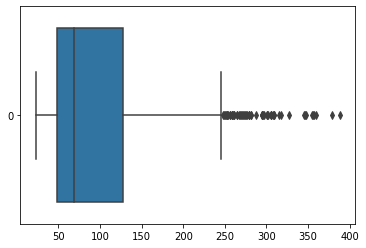

In [17]:
import seaborn as sns
ax = sns.boxplot(data=df['LTC'], orient="h")

Lets look at a histogram of the prices

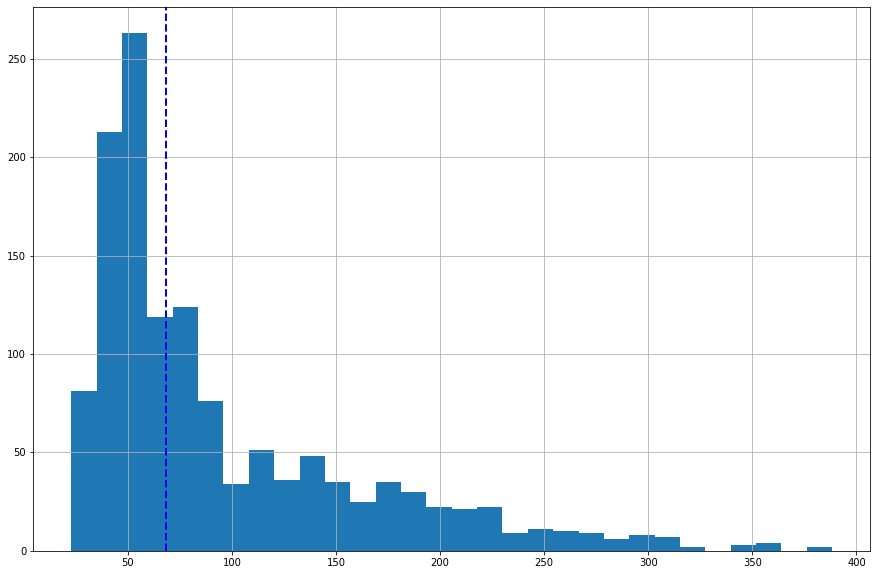

In [79]:
df['LTC'].hist(bins=30, figsize=(15,10)).axvline(df['LTC'].median(), color='b', linestyle='dashed', linewidth=2)

Absolute price plot

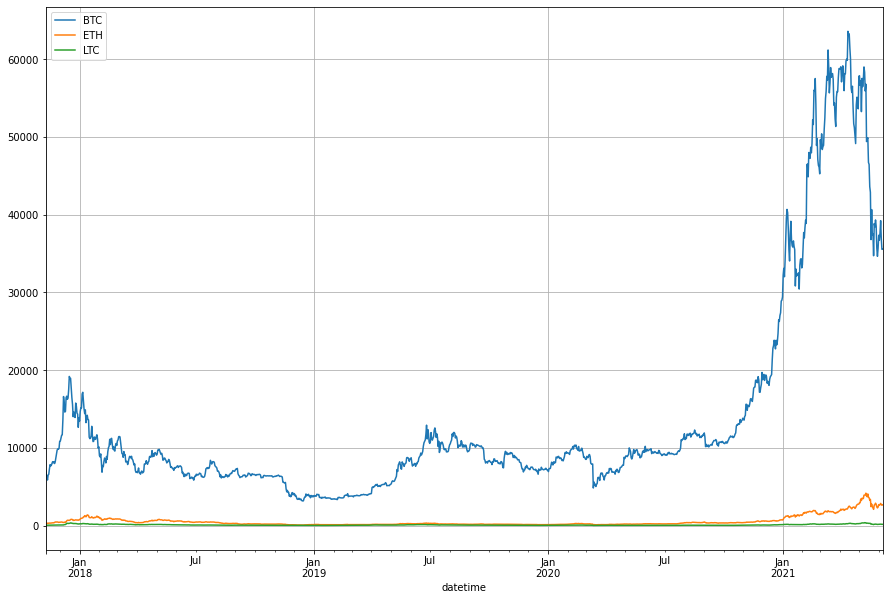

In [81]:
df.plot(grid=True, figsize=(15, 10))

relative plot

We create an axis for each plot separately.

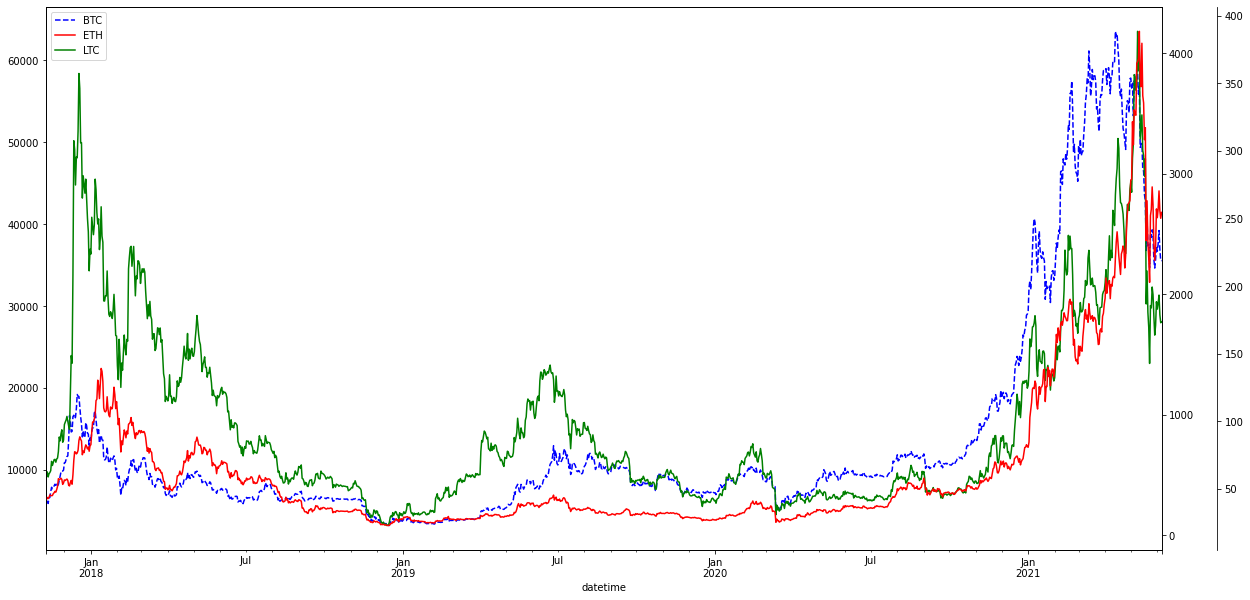

In [19]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# move this axis over to the right a bit - magic.
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.05))

df['BTC'].plot(ax=ax1, style='b--')
df['ETH'].plot(ax=ax1, style='r-', secondary_y=True)  # use a secondary y-axis on the right
df['LTC'].plot(ax=ax2, style='g-')

# legend
ax2.legend([ax1.get_lines()[0],
            ax1.right_ax.get_lines()[0],
            ax2.get_lines()[0]],
           ['BTC', 'ETH', 'LTC'])

generate correlation matrix for heatmap

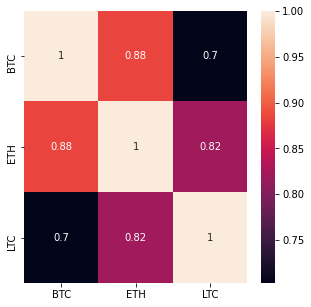

In [23]:

# Compute the correlation matrix
corr = df.corr()

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr, annot=True)

Profitability if I bought one of these when all three were available.

We apply a function to each that takes the current one divided by the first price

In [77]:
df_return = df.apply(lambda x: x / x[0]) # drop null rows
df_return.head()

,BTC,ETH,LTC
datetime,,,
2017-11-09,1.000000,1.000000,1.000000
2017-11-10,0.921682,0.929478,0.916253
2017-11-11,0.889078,0.982696,0.968828
2017-11-12,0.821260,0.952633,0.910360
2017-11-13,0.912867,0.983879,0.946495


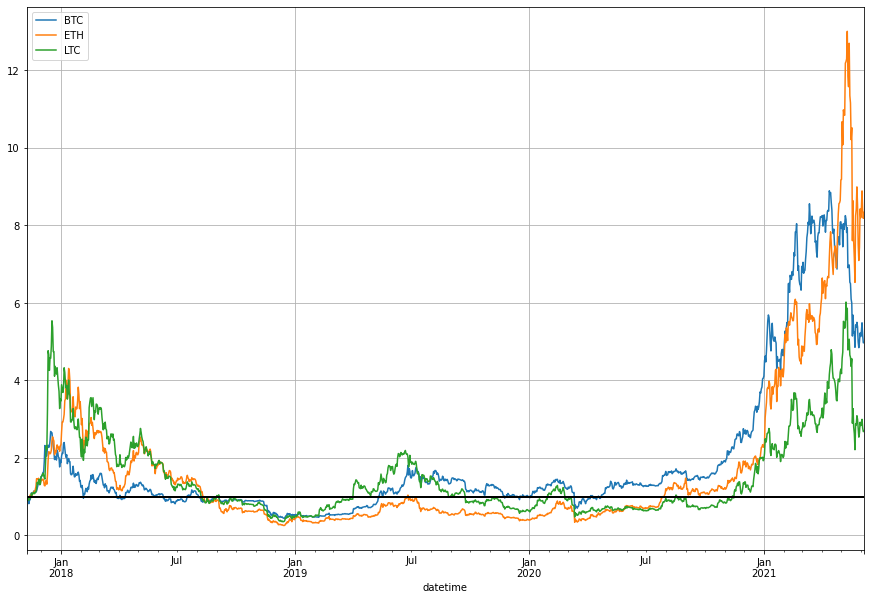

In [73]:
df_return.plot(grid=True, figsize=(15, 10)).axhline(y = 1, color = "black", lw = 2)

what was the percentage increase?

,BTC,ETH,LTC
datetime,,,
2021-06-06,497.364578,833.517988,268.998139


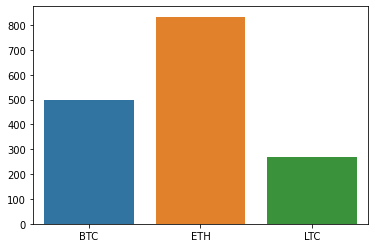

In [74]:
df_perc = df_return.tail(1) * 100
ax = sns.barplot(data=df_perc)
df_perc

How many could we buy for $1000?

,BTC,ETH,LTC
datetime,,,
2017-11-09,0.139899,3.112162,15.508685


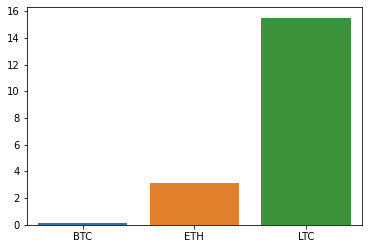

In [75]:
budget = 1000 # USD
df_coins = budget/df.head(1)

ax = sns.barplot(data=df_coins)
df_coins

How much money would we make if we invested $1000 a while ago

,BTC,ETH,LTC
datetime,,,
2021-06-06,4973.645775,8335.179883,2689.98139


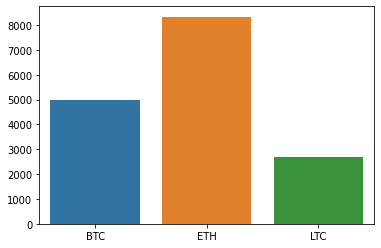

In [76]:
df_profit = df_return.tail(1) * budget

ax = sns.barplot(data=df_profit)
df_profit

# References

* https://towardsdatascience.com/cryptocurrency-analysis-with-python-buy-and-hold-c3b0bc164ffa

* https://towardsdatascience.com/cryptocurrency-analysis-with-python-macd-452ceb251d7c
